<h1>Group assignment team 11</h1>

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns


import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs

import ptitprince as pt

#randomforestclassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

<h2>Datset Preperations</h2>

In [11]:
df = pd.read_csv('tested_molecules-1.csv')
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()

In [12]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [13]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [14]:
data = df.copy(deep=True)
molecules = data.SMILES.apply(Chem.MolFromSmiles)
data.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)
data.loc[:, 'Heterocycles'] = molecules.apply(Descriptors.NumAromaticHeterocycles)
data.loc[:, 'AmideBonds'] = [AllChem.CalcNumAmideBonds(x) for x in molecules]
data.loc[:, 'LipinskiHBA'] = [AllChem.CalcNumLipinskiHBA(x) for x in molecules]
data.loc[:, 'LipinskiHBD'] = [AllChem.CalcNumLipinskiHBD(x) for x in molecules]

In [15]:
data

,SMILES,ALDH1_inhibition,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings,Heterocycles,AmideBonds,LipinskiHBA,LipinskiHBD
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,1.50330,34,8,10,2,463.542,8,4,6.958111e+07,-3.95,178,1,1,3,1,2,10,2
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,3.48110,27,6,7,1,378.457,7,4,3.137659e+06,-3.06,136,0,0,4,3,1,6,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,2.83782,35,8,9,2,477.589,9,5,1.436707e+08,-3.30,184,1,1,4,3,0,9,2
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,4.05510,18,3,5,0,330.609,3,2,1.207136e+04,-1.00,96,0,0,2,1,0,3,0
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1,3.37490,27,6,9,1,419.553,5,4,1.948182e+06,-2.23,140,0,1,3,2,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0,0.05290,19,3,5,1,261.301,4,3,4.581294e+04,-1.88,100,2,2,1,0,2,5,2
996,CCNc1oc(COc2cccc(C)c2)nc1C#N,0,2.86550,19,5,5,1,257.293,5,2,2.727871e+04,-2.48,98,0,0,2,1,0,5,1
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0,1.03540,15,3,4,1,201.229,3,2,4.126498e+03,-2.10,76,0,0,2,1,1,4,2
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0,1.04182,27,10,11,1,392.441,5,3,1.115768e+06,-2.82,144,0,0,3,3,1,10,1


In [81]:
# Check for duplicated rows
duplicated_rows = data.duplicated()
sum_duplicated_rows = duplicated_rows.sum()
print("Amount of duplicated rows:", sum_duplicated_rows)

# Check for missing data
missing_data = data.isnull().sum()
print('Amount of missing data per column:\n', missing_data)

Amount of duplicated rows: 0
Amount of missing data per column:
 SMILES                 0
ALDH1_inhibition       0
MolLogP                0
HeavyAtomCount         0
HAccept                0
Heteroatoms            0
HDonor                 0
MolWt                  0
RotableBonds           0
RingCount              0
Ipc                    0
HallKierAlpha          0
NumValenceElectrons    0
SaturatedRings         0
AliphaticRings         0
AromaticRings          0
Heterocycles           0
AmideBonds             0
LipinskiHBA            0
LipinskiHBD            0
dtype: int64


<h2>Exploratory Data analysis</h2>

NameError: name 'data' is not defined

C:\Users\20192035\AppData\Local\Temp\ipykernel_15312\3481269068.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

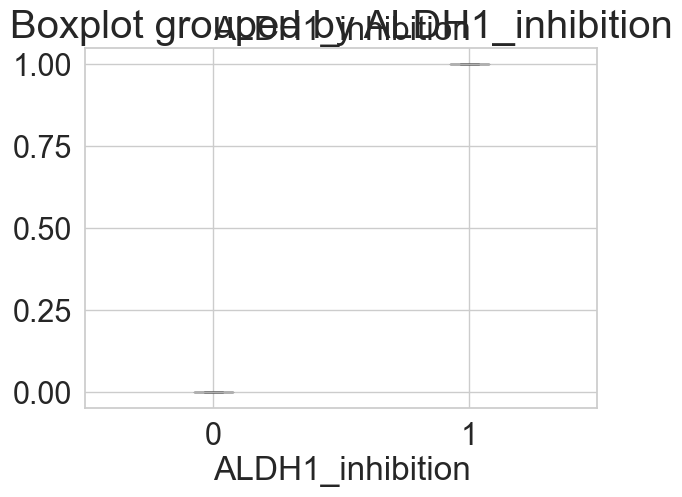

<Figure size 640x480 with 0 Axes>

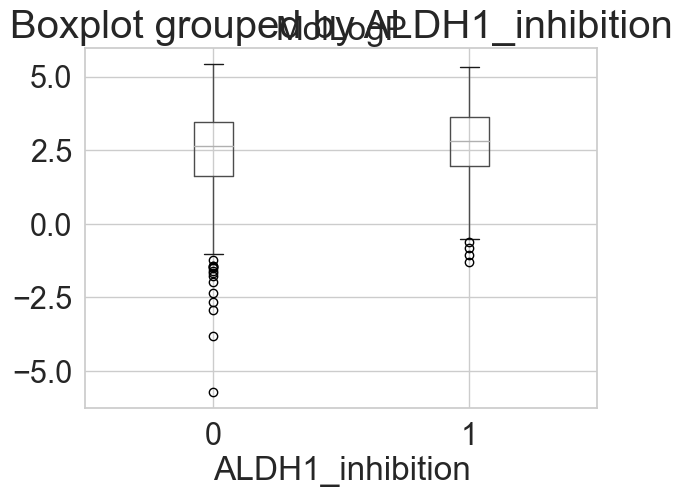

<Figure size 640x480 with 0 Axes>

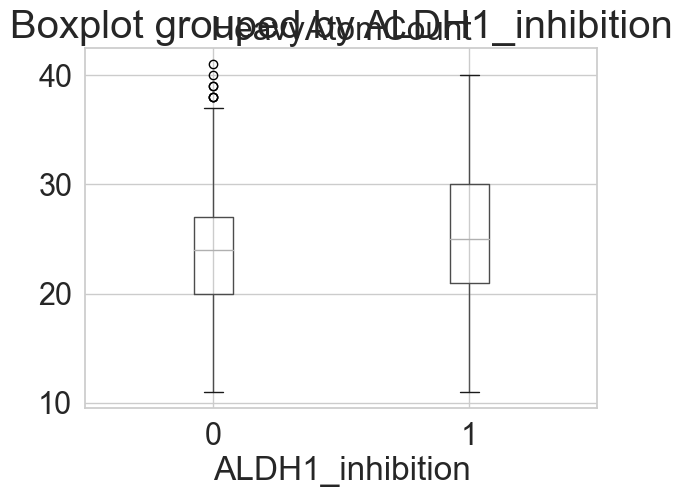

<Figure size 640x480 with 0 Axes>

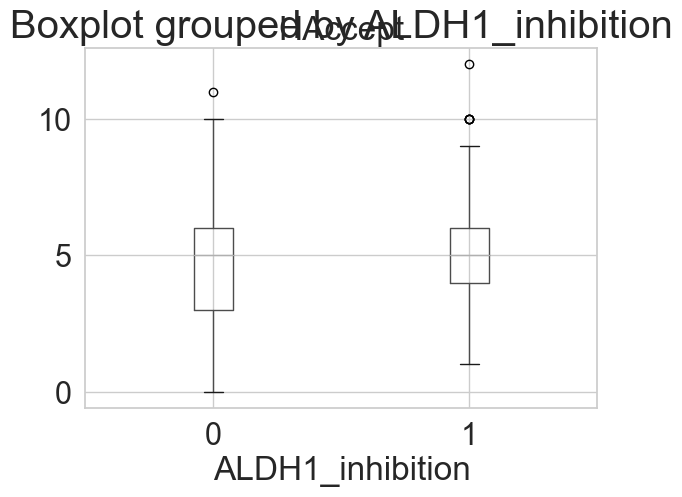

<Figure size 640x480 with 0 Axes>

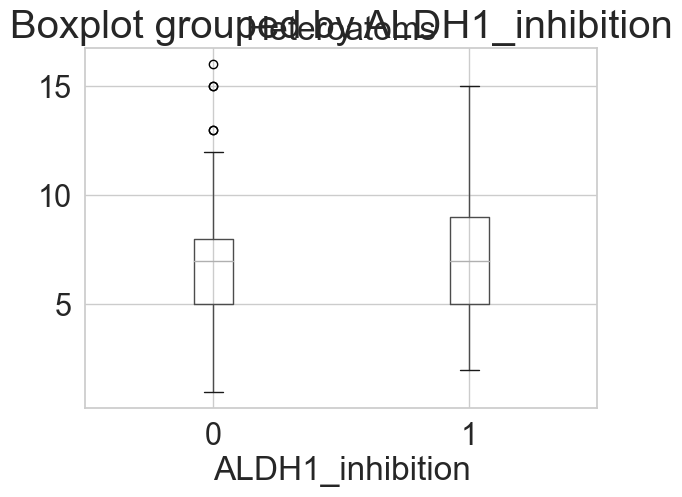

<Figure size 640x480 with 0 Axes>

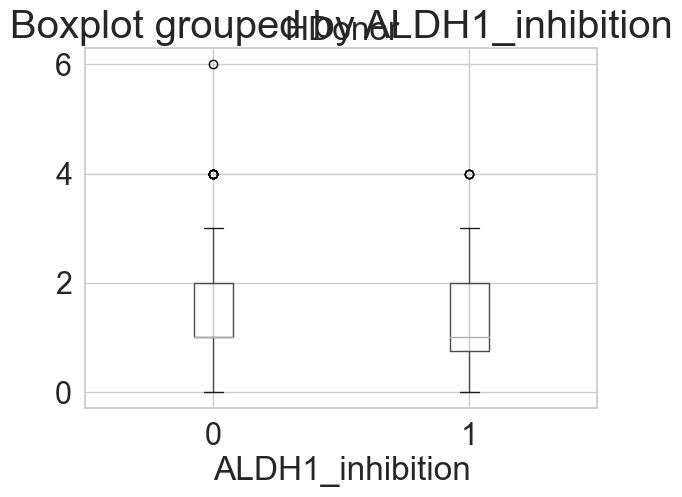

<Figure size 640x480 with 0 Axes>

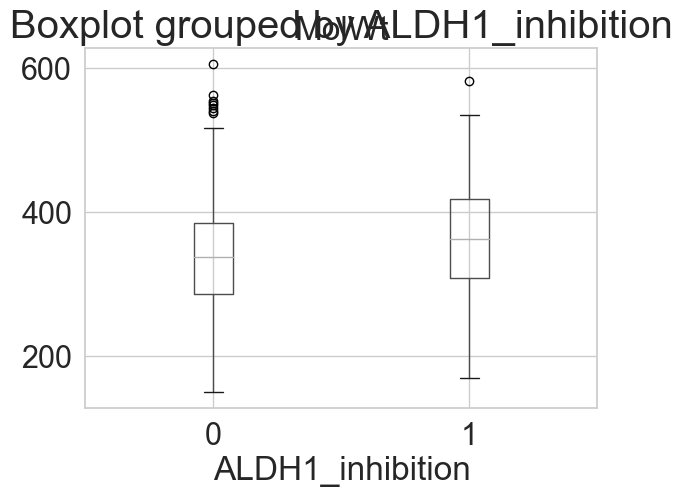

<Figure size 640x480 with 0 Axes>

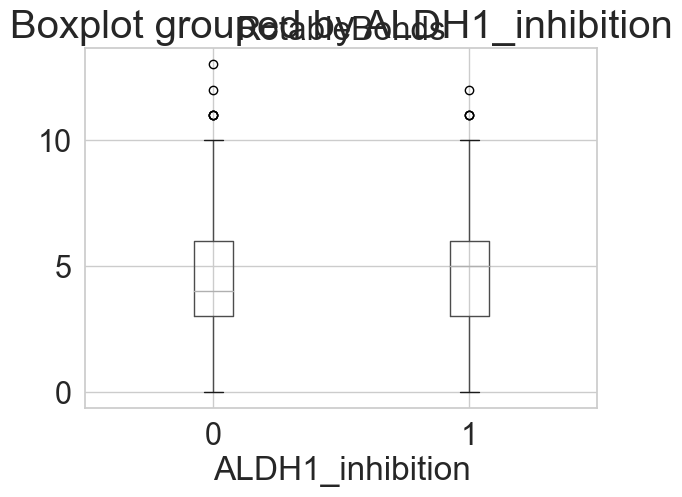

<Figure size 640x480 with 0 Axes>

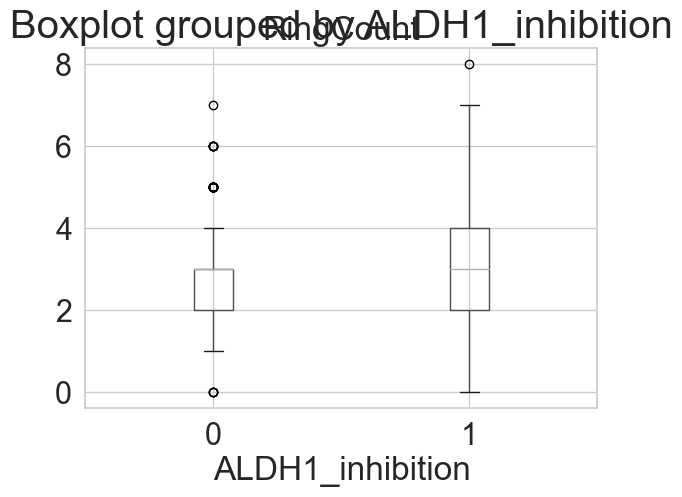

<Figure size 640x480 with 0 Axes>

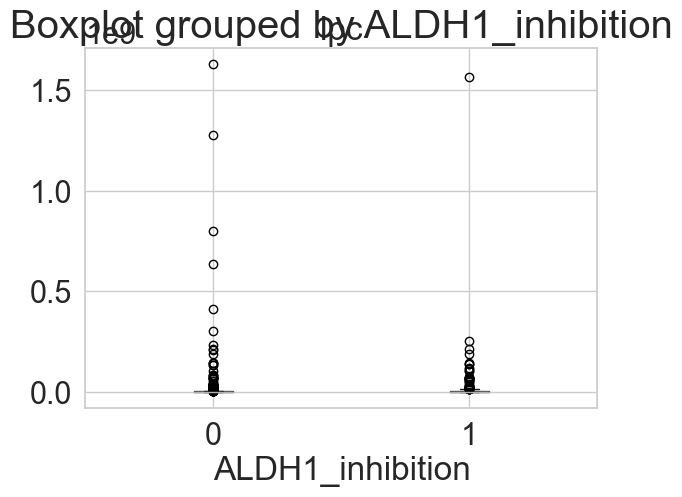

<Figure size 640x480 with 0 Axes>

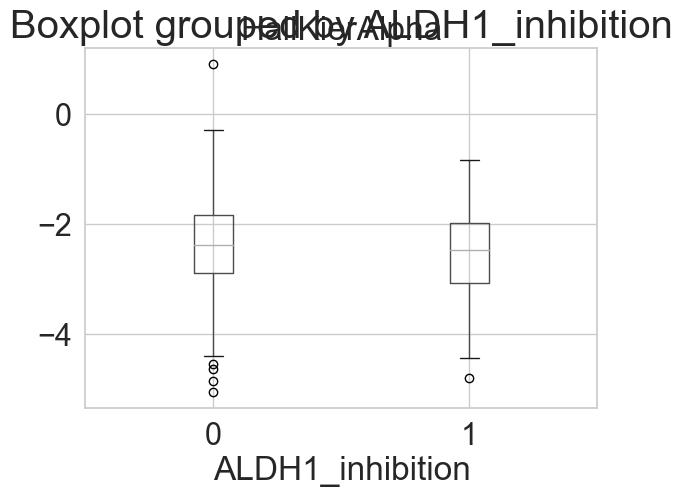

<Figure size 640x480 with 0 Axes>

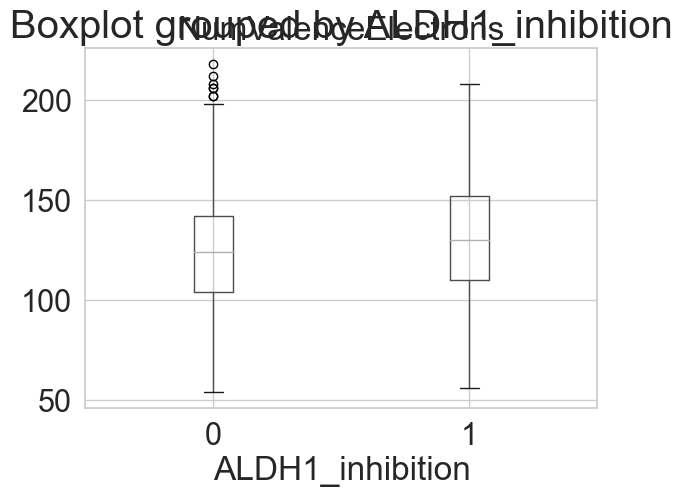

<Figure size 640x480 with 0 Axes>

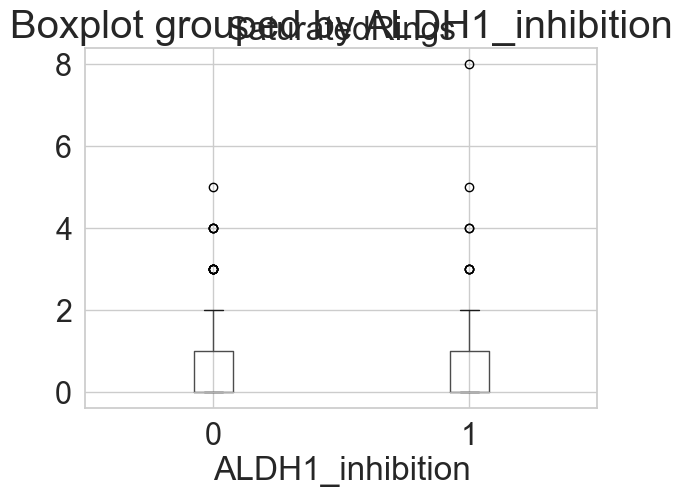

<Figure size 640x480 with 0 Axes>

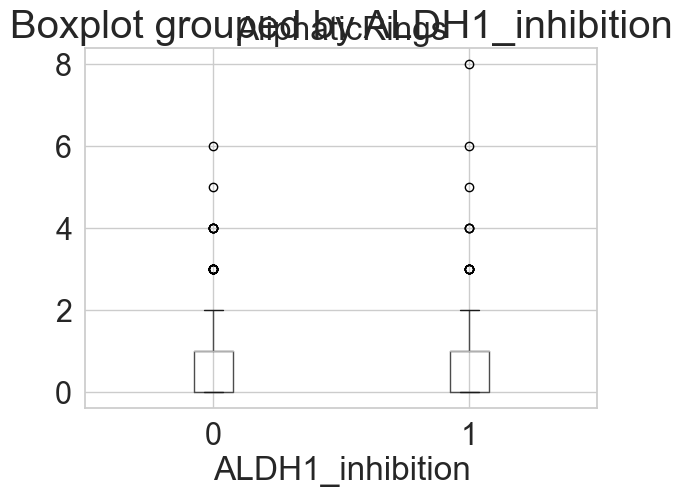

<Figure size 640x480 with 0 Axes>

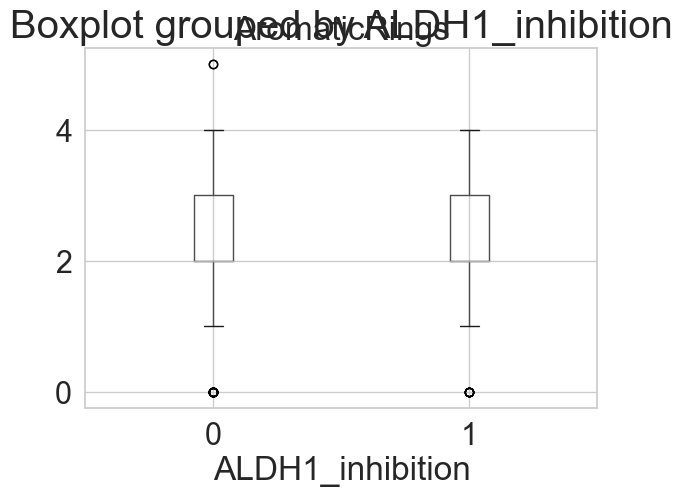

<Figure size 640x480 with 0 Axes>

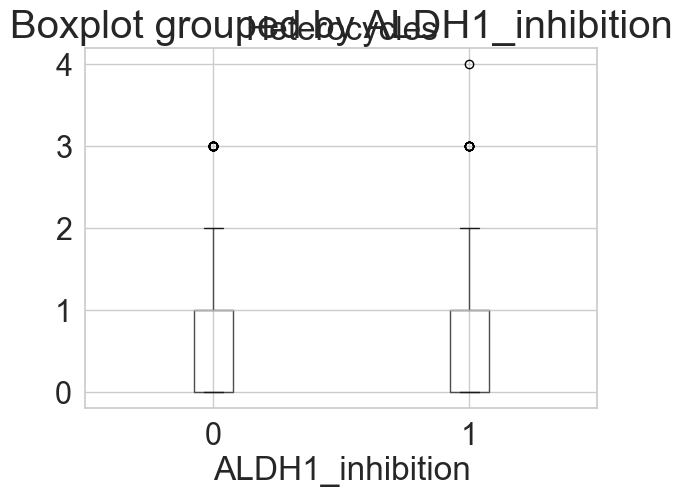

<Figure size 640x480 with 0 Axes>

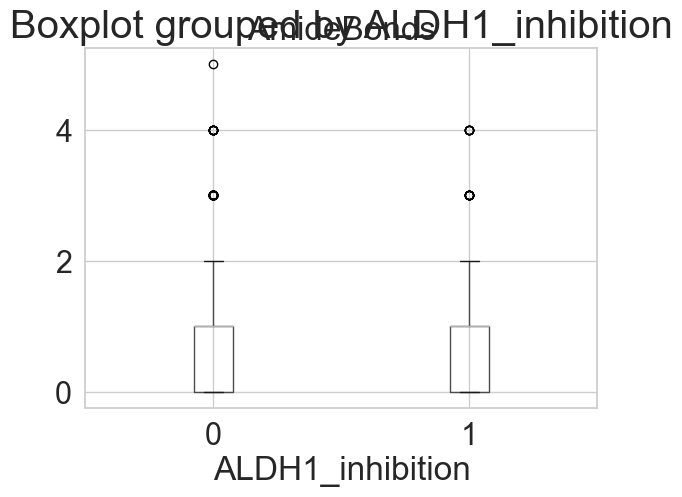

<Figure size 640x480 with 0 Axes>

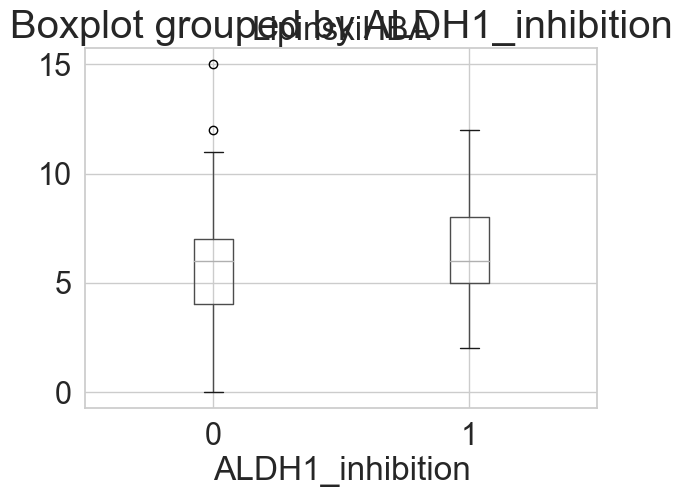

<Figure size 640x480 with 0 Axes>

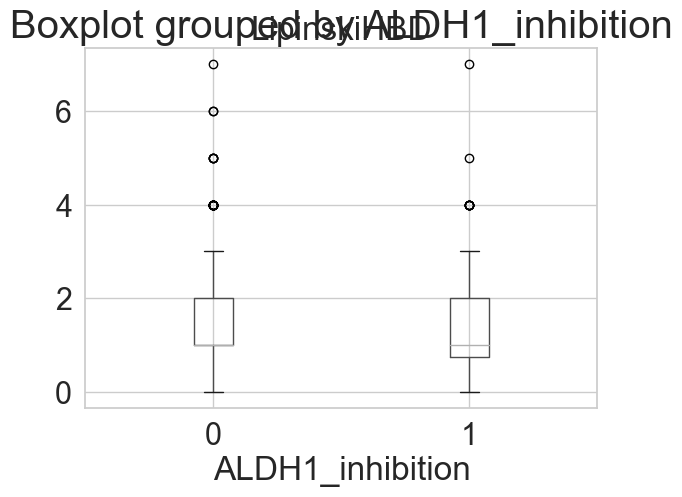

In [83]:
#Endless boxplot generating
data_boxplot = data.select_dtypes(exclude=['object','string'])
for column in data_boxplot:
    plt.figure()
    data_boxplot.boxplot(by='ALDH1_inhibition',column= [column])

D:\Docs\8CC00\8CC00env\lib\site-packages\ptitprince\PtitPrince.py:61: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  hue_mask = np.ones(group_data.size, np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

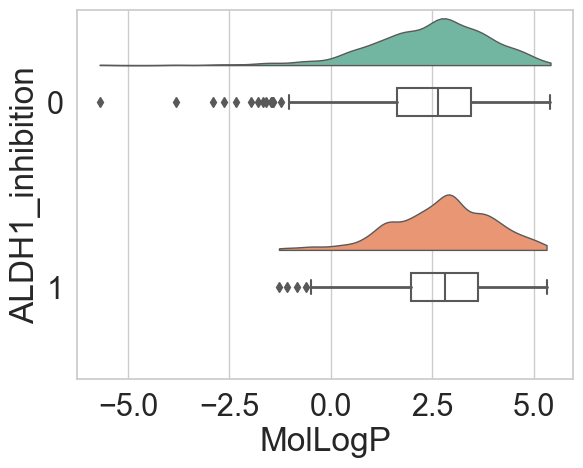

In [68]:
#TODO: The figures are not saving and i do not know why. I think these rain plots are better then the simple boxplots.

import os
import seaborn as sns
import ptitprince as pt

# Variables
savefigs = True
variable_to_fig = 'MolLogP'
figs_dir = r'D:\Docs\8CC00\figs group AP'

# Main code
sns.set(style="whitegrid", font_scale=2)
dx = "ALDH1_inhibition"
dy = variable_to_fig
ort = "h"
pal = "Set2"
sigma = .2

# Create a new figure and axes
f, ax = pt.RainCloud(x=dx, y=dy, data=data, palette=pal, bw=sigma, width_viol=.6, orient=ort, move=.2)

# Set the title and labels
ax.set_title(f"Raincloud plot {dy} vs diagnostic label")
ax.set_ylabel('Diagnostic label')

if savefigs:
    os.makedirs(figs_dir, exist_ok=True)
    fig_path = os.path.join(figs_dir, f'raincloud_{dy}.png')
    f.savefig(fig_path, bbox_inches='tight', facecolor='white')
    print(f"Plot saved at: {fig_path}")

sns.reset_orig()

<h2>Identification of structure-activity relationships</h2>

In [ ]:
#Split data into Test data set and training data set before doing anything.
#X_train, X_test, y_train, y_test = train_test_split(data[features], data['ALDH1_inhibition'], stratify=data['ALDH1_inhibition'],test_size=0.25, random_state=42)

<h2>Selection of top 100</h2>